In [1]:
import pandas as pd
import numpy as np
from sklearn import feature_extraction
from sklearn import linear_model
from sklearn import preprocessing
from scipy import sparse

## Load Data and Train/Test Split(s)

In [2]:
df=pd.read_json("../data/merged_troll_data.json")

In [3]:
df.shape

(332504, 8)

In [4]:
df.sample(5).head()

,content,followers,following,retweet,account_category,created_at,troll,orig_index
294412,We NEED a Special Prosecutor...NOW!! https://t...,57,66,0,NonTroll,2016-10-25 04:26:51,False,2801
330038,RT @tmckernan: From #KenBone: I went into the ...,373,143,1,NonTroll,2016-10-10 13:20:32,False,400554
283123,"@realDonaldTrump you are wrong Donald, it was ...",111,141,0,NonTroll,2016-10-20 02:23:20,False,16201
330288,"RT @atensnut: Hillary calls Trump's remarks ""h...",534,445,1,NonTroll,2016-10-09 03:59:14,False,29403
272847,@realDonaldTrump @TeamTrump @MELANIATRUMP @Iva...,14045,12881,0,NonTroll,2016-10-10 08:42:21,False,65000


In [5]:
ids=pd.read_json("../data/train_test_inds.json")

In [6]:
len(ids.random.train)

266003

## Prepare feature matrix

### Isolate matrices

In [7]:
def getxy(ids, feature_cols=['content', 'followers', 'following', 'retweet'], label_col=['troll']):
    return df[feature_cols].iloc[ids], df[label_col].iloc[ids]

In [8]:
# random
Xrand_train, yrand_train = getxy(ids.random.train)
Xrand_val, yrand_val = getxy(ids.random.val)
Xrand_test, yrand_test = getxy(ids.random.test)

# temporal
Xtemp_train, ytemp_train = getxy(ids.temporal.train)
Xtemp_val, ytemp_val = getxy(ids.temporal.val)
Xtemp_test, ytemp_test = getxy(ids.temporal.test)

In [9]:
Xrand_train.head()

,content,followers,following,retweet
204024,RT @businessinsider: OBAMA: The press doesn’t ...,14525,3311,1
45854,Review: Generation Startup https://t.co/lej8O8...,3086,2387,1
199686,RT @Kidrambler: @TomiLahren Vote for Gary John...,1117,3742,1
115712,in interpersonal relations with pple who are m...,936,582,1
245728,RT @PeterTownsend7: The Real #WarOnWomen #isi...,2891,1615,1


In [10]:
Xrand_train.shape, yrand_train.shape

((266003, 4), (266003, 1))

### Tokenize content

In [11]:
vocab_size=5000
tokenizer=feature_extraction.text.CountVectorizer(stop_words='english', max_features=vocab_size)
tokenizer=tokenizer.fit(df['content'])

In [12]:
Xrand_train_tok=tokenizer.transform(Xrand_train['content'])
Xrand_val_tok=tokenizer.transform(Xrand_val['content'])
Xrand_test_tok=tokenizer.transform(Xrand_test['content'])

Xtemp_train_tok=tokenizer.transform(Xtemp_train['content'])
Xtemp_val_tok=tokenizer.transform(Xtemp_val['content'])
Xtemp_test_tok=tokenizer.transform(Xtemp_test['content'])

In [13]:
Xrand_train_tok.shape # token matrix dim = n x vocab_size

(266003, 5000)

### Standardize followers/following

In [14]:
# one for each split
rand_scaler = preprocessing.StandardScaler().fit(Xrand_train[['followers','following']])
temp_scaler = preprocessing.StandardScaler().fit(Xtemp_train[['followers','following']])

In [15]:
print('rand means and scales: {}, {}'.format(rand_scaler.mean_, rand_scaler.scale_))
print('temp means and scales: {}, {}'.format(temp_scaler.mean_, rand_scaler.scale_))

rand means and scales: [8154.90645218 3016.03233422], [219679.05451009   7816.52064337]
temp means and scales: [8757.68069533 3020.22409146], [219679.05451009   7816.52064337]


They are very close. Could probably just use a single one, but I will use both anyways, in case it makes a difference.

In [16]:
col_to_std = ['followers', 'following']
Xrand_train[col_to_std]=rand_scaler.transform(Xrand_train[col_to_std])
Xrand_val[col_to_std]=rand_scaler.transform(Xrand_val[col_to_std])
Xrand_test[col_to_std]=rand_scaler.transform(Xrand_test[col_to_std])

Xtemp_train[col_to_std]=temp_scaler.transform(Xtemp_train[col_to_std])
Xtemp_val[col_to_std]=temp_scaler.transform(Xtemp_val[col_to_std])
Xtemp_test[col_to_std]=temp_scaler.transform(Xtemp_test[col_to_std])

In [17]:
Xrand_train[col_to_std].head()

,followers,following
204024,0.028997,0.037736
45854,-0.023074,-0.080475
199686,-0.032037,0.092876
115712,-0.032861,-0.311396
245728,-0.023962,-0.179240


### Binarize the boolean outcome

In [18]:
yrand_train.head()

,troll
204024,False
45854,True
199686,False
115712,True
245728,False


In [19]:
bool_to_bin = lambda x: 1 if x else 0
yrand_train['troll'] = yrand_train['troll'].apply(bool_to_bin)
yrand_train.head()

,troll
204024,0
45854,1
199686,0
115712,1
245728,0


In [20]:
yrand_val['troll'] = yrand_val['troll'].apply(bool_to_bin)
yrand_test['troll'] = yrand_test['troll'].apply(bool_to_bin)

ytemp_train['troll'] = ytemp_train['troll'].apply(bool_to_bin)
ytemp_val['troll'] = ytemp_val['troll'].apply(bool_to_bin)
ytemp_test['troll'] = ytemp_test['troll'].apply(bool_to_bin)

### Concatenate features

In [21]:
def concatenate_features(tok_matrix, data_df):
    """ concatenate the tokenized matrix (scipy.sparse) with other features """
    sparse_cols = sparse.csr_matrix(data_df[['followers', 'following', 'retweet']])
    combined = sparse.hstack([tok_matrix, sparse_cols])
    return combined

In [22]:
Xrand_train_combined = concatenate_features(Xrand_train_tok, Xrand_train)
Xrand_val_combined = concatenate_features(Xrand_val_tok, Xrand_val)
Xrand_test_combined = concatenate_features(Xrand_test_tok, Xrand_test)

Xtemp_train_combined = concatenate_features(Xtemp_train_tok, Xtemp_train)
Xtemp_val_combined = concatenate_features(Xtemp_val_tok, Xtemp_val)
Xtemp_test_combined = concatenate_features(Xtemp_test_tok, Xtemp_test)

In [23]:
Xrand_train_combined.shape # combined is n * tok_dim + 3 features

(266003, 5003)

## Train the model(s)

### Using only text

In [24]:
# random split
logit_rand = linear_model.LogisticRegression().fit(Xrand_train_tok, yrand_train['troll'])

In [25]:
logit_rand.score(Xrand_val_tok, yrand_val['troll'])

0.9000601503759399

In [26]:
logit_rand.score(Xrand_test_tok, yrand_test['troll'])

0.9054464527382635

In [27]:
# temporal split
logit_temp = linear_model.LogisticRegression().fit(Xtemp_train_tok, ytemp_train['troll'])

In [28]:
logit_temp.score(Xtemp_val_tok, ytemp_val['troll'])

0.8973533834586466

In [29]:
logit_temp.score(Xtemp_test_tok, ytemp_test['troll'])

0.8965444648281254

### Using all features

In [30]:
# random split
logit_rand_all = linear_model.LogisticRegression().fit(Xrand_train_combined, yrand_train['troll'])

In [31]:
logit_rand_all.score(Xrand_train_combined, yrand_train['troll'])

0.9733612026932027

In [32]:
logit_rand_all.score(Xrand_val_combined, yrand_val['troll'])

0.9673383458646616

In [33]:
logit_rand_all.score(Xrand_test_combined, yrand_test['troll'])

0.9657153168325765

In [34]:
# temporal split
logit_temp_all = linear_model.LogisticRegression().fit(Xtemp_train_combined, ytemp_train['troll'])

In [35]:
logit_temp_all.score(Xtemp_train_combined, ytemp_train['troll'])

0.9747784799419555

In [36]:
logit_temp_all.score(Xtemp_val_combined, ytemp_val['troll'])

0.953593984962406

In [37]:
logit_temp_all.score(Xtemp_test_combined, ytemp_test['troll'])

0.9577757059938047

## Summary of results


- Using only the text features, logistic regression is amazingly able to classify trolls with ~90.5% accuracy on the random test set and ~89.6% accuracy on the temporal test set.

- If we include followers/following/retweets, logistic regression is able to classify trolls with ~96.6% accuracy on the random test set and ~95.8% accuracy on the temporal test set.

- Amazingly, logistic regression fits the data in about 5 seconds on a 6-core machine.

## Analysis of Coefficients

In [38]:
import matplotlib.pyplot as plt

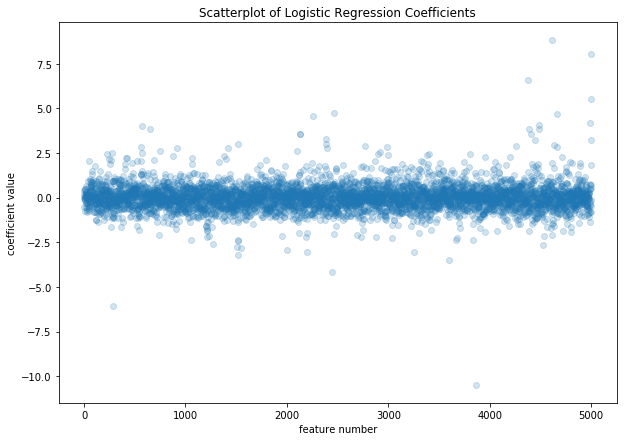

In [39]:
logit_coefs=logit_temp_all.coef_[0]
x_vals=np.arange(len(logit_coefs))
plt.figure(figsize=(10,7))
plt.scatter(x_vals, logit_coefs, alpha=0.2)
plt.xlabel('feature number')
plt.ylabel('coefficient value')
plt.title('Scatterplot of Logistic Regression Coefficients')
plt.show()

In [40]:
coeff_rankings=list(zip(x_vals, logit_coefs))

We can try pulling out the words / features which are most useful for the model. These are the coefficients far from 0.

In [41]:
pos_important = sorted(coeff_rankings, key=lambda x: x[1], reverse=True)[:10]
pos_important

[(4617, 8.838763836634316),
 (5002, 8.039423039887515),
 (4378, 6.5843513614661795),
 (4998, 5.515205594483098),
 (2463, 4.713816938695965),
 (4664, 4.697230741066687),
 (2262, 4.574340386508764),
 (4987, 4.201012425170983),
 (4482, 4.062565213624058),
 (568, 4.033387244842914)]

In [42]:
neg_important = sorted(coeff_rankings, key=lambda x: x[1], reverse=False)[:10]
neg_important

[(3868, -10.51575648211737),
 (284, -6.068239527626553),
 (2442, -4.1449520207607184),
 (3601, -3.4991128677483365),
 (1521, -3.208875507439863),
 (3251, -3.0724362016697913),
 (2195, -3.0477830181996866),
 (2000, -2.922491049274889),
 (1547, -2.824736998203203),
 (1510, -2.7610561488103897)]

We see that feature `5002` was very important, which was the retweet binary variable. Everything else seems to be a token from our vocabulary! Let's investigate these.

In [43]:
pos_words = [word for word, val in tokenizer.vocabulary_.items() if (val == pos_important).any()]

In [44]:
pos_words

['½ï',
 'tâ',
 'imnotwithher',
 'blackskinisnotacrime',
 'talibkweli',
 'youâ',
 'trumpforpresident',
 'thingsmoretrustedthanhillary',
 'jstines3']

In [45]:
neg_words = [word for word, val in tokenizer.vocabulary_.items() if (val == neg_important).any()]

In [46]:
neg_words

['rt',
 'electionday',
 'en',
 'que',
 'amp',
 'el',
 'johnkstahlusa',
 'gt',
 'htt',
 'para']

## Cross-validate for Hyperparameters

In [51]:
# combine train/val
Xrand_train_cv = sparse.vstack([Xrand_train_combined, Xrand_val_combined])
yrand_train_cv = np.concatenate([yrand_train['troll'], yrand_val['troll']], axis=0)
Xtemp_train_cv = sparse.vstack([Xtemp_train_combined, Xtemp_val_combined])
ytemp_train_cv = np.concatenate([ytemp_train['troll'], ytemp_val['troll']], axis=0)

In [52]:
Xrand_train_cv.shape, yrand_train_cv.shape

((299253, 5003), (299253,))

In [53]:
# random split
logit_rand_all_cv = linear_model.LogisticRegressionCV().fit(Xrand_train_cv, yrand_train_cv)

In [54]:
logit_rand_all_cv.score(Xrand_train_cv, yrand_train_cv)

0.9724681122662096

In [55]:
logit_rand_all_cv.score(Xrand_test_combined, yrand_test)

0.9669182881717843

About 0.1% improvement (relatively small).

In [56]:
# temporal split
logit_temp_all_cv = linear_model.LogisticRegressionCV().fit(Xtemp_train_cv, ytemp_train_cv)

In [57]:
logit_temp_all_cv.score(Xtemp_train_cv, ytemp_train_cv)

0.970245912321681

In [58]:
logit_temp_all_cv.score(Xtemp_test_combined, ytemp_test)

0.9590388258999729

Also ~0.1% improvement.